## Tutorial on Parallel Parcels with MPI and `dask` field-chunking

Parcels can be run in Parallel with MPI. To do this, first follow the installation instructions at http://oceanparcels.org/#parallel_install.

### Splitting the ParticleSet with MPI

Once you have installed a parallel version of Parcels, you can simply run your script with

```
mpirun -np <np> python <yourscript.py>
```
Where `<np>` is the number of processors you want to use

Parcels will then split the `ParticleSet` into `<np>` smaller ParticleSets, based on a `sklearn.cluster.KMeans` clustering. Each of those smaller `ParticleSets` will be executed by one of the `<np>` MPI processors.

Note that in principle this means that all MPI processors need access to the full `FieldSet`, which can be Gigabytes in size for large global datasets. Therefore, efficient parallelisation only works if at the same time we also chunk the `FieldSet` into smaller domains

### Chunking the FieldSet with dask

The basic idea of field-chunking in Parcels is that we use the `dask` library to load only these regions of the `Field` that are occupied by `Particles`. The advantage is that if different MPI procesors take care of Particles in different parts of the domain, each only needs to load a small section of the full `FieldSet` (although note that this load-balancing functionality is still in [development](#Future-developments:-load-balancing)). Furthermore, the field-chunking in principle makes the `indices` keyword superfluous, as Parcels will determine which part of the domain to load itself.

The default behaviour is for `dask` to control the chunking, via a call to `da.from_array(data, chunks='auto')`. The chunksizes are then determined by the layout of the NetCDF files. 

However, in tests we have experienced that this may not necessarily be the most efficient chunking. Therefore, Parcels provides control over the chunksize via the `chunksize` keyword in `Field` creation, which requires a dictionary that sets the typical size of chunks for each dimension.

It is strongly encouraged to explore what the best value for chunksize is for your experiment, which will depend  on the `FieldSet`, the `ParticleSet` and the type of simulation (2D versus 3D). As a guidance, we have found that chunksizes in the zonal and meridional direction of approximately around 128 to 512 are typically most effective. The binning relates to the size of the model and its data size, so power-of-two values are advantageous but not required.

The notebook below shows an example script to explore the scaling of the time taken for `pset.execute()` as a function of zonal and meridional `chunksize` for a dataset from the [CMEMS](http://marine.copernicus.eu/) portal.

In [1]:
%pylab inline
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4
from datetime import timedelta as delta
import numpy as np
from glob import glob
import os
import time
import psutil
import matplotlib.pyplot as plt

def set_cmems_fieldset(cs):
    data_dir_head = "/data/oceanparcels/input_data"
    data_dir = os.path.join(data_dir_head, "CMEMS/GLOBAL_REANALYSIS_PHY_001_030/")
    files = sorted(glob(data_dir+"mercatorglorys12v1_gl12_mean_201607*.nc"))
    variables = {'U': 'uo', 'V': 'vo'}
    dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

    if cs not in ['auto', False]:
        cs = {'time': ('time', 1), 'lat': ('latitude', cs), 'lon': ('longitude', cs)}
    return FieldSet.from_netcdf(files, variables, dimensions, chunksize=cs)

func_time = []
mem_used_GB = []
chunksize = [128, 256, 512, 768, 1024, 1280, 1536, 1792, 2048, 2610, 'auto', False]
for cs in chunksize:
    
    fieldset = set_cmems_fieldset(cs)
    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=[0], lat=[0], repeatdt=delta(hours=1))

    tic = time.time()
    pset.execute(AdvectionRK4, dt=delta(hours=1))
    func_time.append(time.time()-tic)
    process = psutil.Process(os.getpid())
    mem_B_used = process.memory_info().rss
    mem_used_GB.append(mem_B_used / (1024 * 1024))


Populating the interactive namespace from numpy and matplotlib


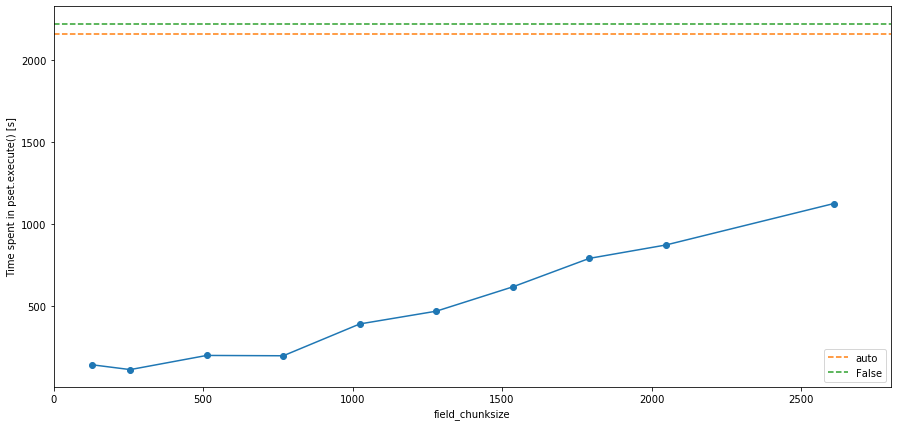

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7)) 

ax.plot(chunksize[:-2], func_time[:-2], 'o-')
ax.plot([0, 2800], [func_time[-2], func_time[-2]], '--', label=chunksize[-2])
ax.plot([0, 2800], [func_time[-1], func_time[-1]], '--', label=chunksize[-1])
plt.xlim([0, 2800])
plt.legend()
ax.set_xlabel('chunksize')
ax.set_ylabel('Time spent in pset.execute() [s]')
plt.show()

The plot above shows that in this case, `chunksize='auto'` and `chunksize=False` (the two dashed lines) are roughly the same speed, but that the fastest run is for `chunksize=(1, 256, 256)`. But note that the actual thresholds and numbers depend on the `FieldSet` used and the specifics of your experiment.

Furthermore, one of the major advantages of field chunking is the efficient utilization of memory. This permits the distribution of the particle advection to many cores, as otherwise the processing unit (e.g. a CPU core; a node in a cluster) would exhaust the memory rapidly. This is shown in the following plot of the memory behaviour.

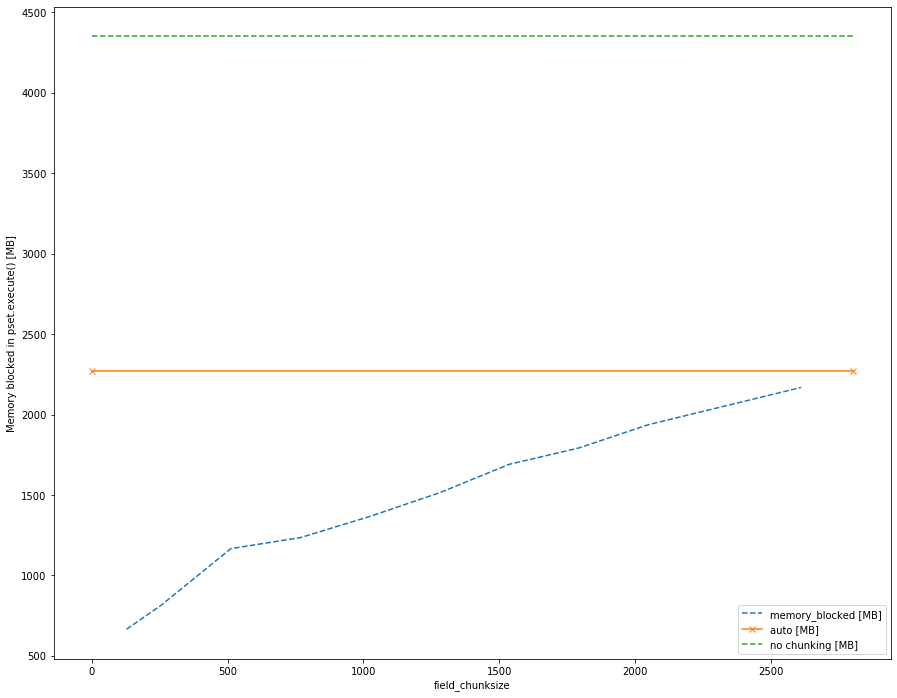

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.plot(chunksize[:-2], mem_used_GB[:-2], '--', label="memory_blocked [MB]")
ax.plot([0, 2800], [mem_used_GB[-2], mem_used_GB[-2]], 'x-', label="auto [MB]")
ax.plot([0, 2800], [mem_used_GB[-1], mem_used_GB[-1]], '--', label="no chunking [MB]")
plt.legend()
ax.set_xlabel('chunksize')
ax.set_ylabel('Memory blocked in pset.execute() [MB]')
plt.show()

It can clearly be seen that with `chunksize=False` (green line), all Field data are loaded in full directly into memory, which can lead to MPI-run simulations being aborted for memory reasons. Furthermore, one can see that even the automatic method is not optimal, and optimizing the chunksize for a specific hydrodynamic dataset can make a large difference to the memory used. 

It may - depending on your simulation goal -  be necessary to tweak the chunksize to leave more memory space for additional particles that are being simulated. Since particles and fields share the same memory space, lower memory utilisation by the `FieldSet` means more memory available for a larger `ParticleSet`. 

Also note that the above example is for a 2D application. For 3D applications, the `chunksize=False` will almost always be slower than `chunksize='auto'` or any dictionary, and is likely to run into insufficient memory issues, raising a `MemoryError`. The plot below shows the same analysis as above, but this time for a set of simulations using the full 3D CMEMS code. In this case, the `chunksize='auto'` is about two orders of magnitude faster than running without chunking, and about 7.5 times faster than with minimal chunk capacity (i.e. `chunksize=(1, 128, 128)`). 

Choosing too small chunksizes can make the code slower, again highlighting that it is wise to explore which chunksize is best for your experiment before you perform it.

In [3]:
from parcels import AdvectionRK4_3D
def set_cmems_fieldset_3D(cs):
    data_dir_head = "/data/oceanparcels/input_data"
    data_dir = os.path.join(data_dir_head, "CMEMS/GLOBAL_REANALYSIS_PHY_001_030/")
    files = sorted(glob(data_dir+"mercatorglorys12v1_gl12_mean_201607*.nc"))
    variables = {'U': 'uo', 'V': 'vo'}
    dimensions = {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}

    if cs not in ['auto', False]:
        cs = {'time': ('time', 1), 'depth': {'depth', 1}, 'lat': ('latitude', cs), 'lon': ('longitude', cs)}
    return FieldSet.from_netcdf(files, variables, dimensions, chunksize=cs)

chunksize_3D = [128, 256, 512, 768, 1024, 1280, 1536, 1792, 2048, 2610, 'auto', False]
func_time3D = []
for cs in chunksize_3D:
    
    fieldset = set_cmems_fieldset_3D(cs)
    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=[0], lat=[0], repeatdt=delta(hours=1))

    tic = time.time()
    pset.execute(AdvectionRK4_3D, dt=delta(hours=1))
    func_time3D.append(time.time()-tic)

Computed 3D field advection.


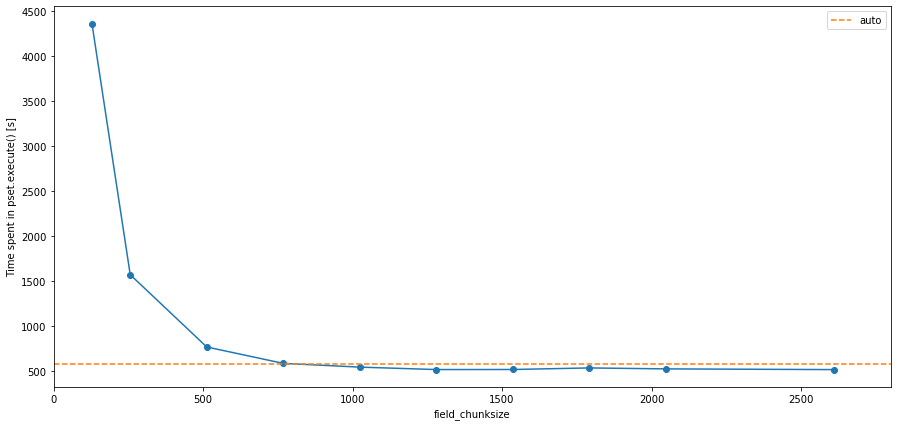

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7)) 

ax.plot(chunksize[:-2], func_time3D[:-2], 'o-')
ax.plot([0, 2800], [func_time3D[-2], func_time3D[-2]], '--', label=chunksize_3D[-2])
plt.xlim([0, 2800])
plt.legend()
ax.set_xlabel('chunksize')
ax.set_ylabel('Time spent in pset.execute() [s]')
plt.show()

### Future developments: load-balancing

The current implementation of MPI parallelisations in Parcels is still fairly rudimentary. In particular, we will continue to develop the load-balancing of the `ParticleSet`.

With load-balancing we mean that `Particles` that are close together are ideally on the same MPI processor. Practically, it means that we need to take care how `Particles` are spread over chunks and processors. See for example the two figures below:

![](http://oceanparcels.org/images/parcelsParallel.png)
*Example of load-balancing for Particles. The domain is chunked along the thick lines, and the orange and blue particles are on separate MPI processors. Before load-balancing (left panel), two chuncks in the centre of the domain have both orange and blue particles. After the load-balancing (right panel), the Particles are redistributed over the processors so that the number of chunks and particles per processor is optimised.*

The difficulty is that since we don't know how the `ParticleSet` will disperse over time, we need to do this load-balancing 'on the fly'. If you to contribute to the optimisation of the load-balancing, please leave a message on [github](https://github.com/OceanParcels/parcels/issues)!